<a href="https://colab.research.google.com/github/miguelruor/GeneticEvolution/blob/main/GeneticEvolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook for computing an estimation of Hitting Time with random time between measurements with Exponential Distribution. This means every measure time is given by the jumps of a Poisson Process

# Libraries

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import expm
from scipy.sparse import csr_matrix
from scipy.linalg import norm
from scipy.sparse.linalg import expm_multiply
from scipy.stats import expon
import pandas as pd
import json
import uuid

In [2]:
from pathlib import Path

# Function to read all name files in a folder
def ls(ruta = Path.cwd()): 
    return [arch.name for arch in Path(ruta).iterdir() if arch.is_file()]

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importation of graphs

In [4]:
dir_file_2phen = "/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_2phen/genotype_space/gspace.gml"
dir_file_4phen = "/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/genotype_space/gspace.gml"

In [5]:
gspace_2phen = nx.read_gml(dir_file_2phen, label='id')
gspace_4phen = nx.read_gml(dir_file_4phen, label='id')

# Identifying genotype networks

### Maximum number of steps to find a novel phenotype

In [6]:
gspace_2phen.nodes[0].keys()

dict_keys(['label', 'sequence', 'phenotypeName', 'phenotypeIndex', 'node_novelPhen', 'steps_novelPhen', 'nodes_novelPhen'])

In [7]:
gspace_2phen.nodes[0]['steps_novelPhen']

1

In [8]:
maxSteps = 0

for v in gspace_4phen.nodes:
  if gspace_4phen.nodes[v]['steps_novelPhen'] != 'infinity' and gspace_4phen.nodes[v]['steps_novelPhen'] > maxSteps:
    maxSteps = gspace_4phen.nodes[v]['steps_novelPhen']
  
maxSteps

5

In [9]:
maxSteps_2 = 0

for v in gspace_2phen.nodes:
  if gspace_2phen.nodes[v]['steps_novelPhen'] != 'infinity' and gspace_2phen.nodes[v]['steps_novelPhen'] > maxSteps_2:
    maxSteps_2 = gspace_2phen.nodes[v]['steps_novelPhen']
  
maxSteps_2

8

Genotypes at n steps away from a novel phenotype, n=1,2,3,..., maxSteps (four phenotype graph)

In [10]:
vertex_nSteps = {}
for n in range(1, maxSteps+1):
  vertex_nSteps[n] = []
vertex_nSteps['infinity'] = []

for v in gspace_4phen.nodes:
  vertex_nSteps[gspace_4phen.nodes[v]['steps_novelPhen']].append(v)

In [11]:
for i in vertex_nSteps:
  print("Nodos a", i, "pasos de encontrar un nuevo fenotipo: ", len(vertex_nSteps[i]))

Nodos a 1 pasos de encontrar un nuevo fenotipo:  254
Nodos a 2 pasos de encontrar un nuevo fenotipo:  205
Nodos a 3 pasos de encontrar un nuevo fenotipo:  99
Nodos a 4 pasos de encontrar un nuevo fenotipo:  18
Nodos a 5 pasos de encontrar un nuevo fenotipo:  3
Nodos a infinity pasos de encontrar un nuevo fenotipo:  0


Genotypes at n steps away from a novel phenotype, n=1,2,3,..., maxSteps (two phenotype graph)

In [12]:
vertex_nSteps_2 = {}
for n in range(1, maxSteps_2+1):
  vertex_nSteps_2[n] = []
vertex_nSteps_2['infinity'] = []

for v in gspace_2phen.nodes:
  vertex_nSteps_2[gspace_2phen.nodes[v]['steps_novelPhen']].append(v)

In [13]:
for i in vertex_nSteps_2:
  print("Nodos a", i, "pasos de encontrar un nuevo fenotipo: ", len(vertex_nSteps_2[i]))

Nodos a 1 pasos de encontrar un nuevo fenotipo:  87
Nodos a 2 pasos de encontrar un nuevo fenotipo:  136
Nodos a 3 pasos de encontrar un nuevo fenotipo:  114
Nodos a 4 pasos de encontrar un nuevo fenotipo:  36
Nodos a 5 pasos de encontrar un nuevo fenotipo:  12
Nodos a 6 pasos de encontrar un nuevo fenotipo:  6
Nodos a 7 pasos de encontrar un nuevo fenotipo:  4
Nodos a 8 pasos de encontrar un nuevo fenotipo:  1
Nodos a infinity pasos de encontrar un nuevo fenotipo:  0


### Identifying genotype networks

In [14]:
phenIndex_4phen = {'Ascl2': 0, 'Bbx': 1, 'Foxa2': 2, 'Mafb': 3}
phenIndex_2phen = {'Bbx': 0, 'Foxa2': 1}

In [15]:
genotype_networks_4phen = {'Ascl2': {}, 'Bbx': {}, 
                           'Foxa2': {}, 'Mafb': {}}
genotype_networks_2phen = {'Bbx': {}, 'Foxa2': {}}

In [16]:
for phen in phenIndex_4phen:
  genotype_networks_4phen[phen]['phenotype'] = phen
  genotype_networks_4phen[phen]['phenotype_id'] = phenIndex_4phen[phen]
  genotype_networks_4phen[phen]['nodes'] = []
  genotype_networks_4phen[phen]['total_nodes'] = 0

for phen in phenIndex_2phen:
  genotype_networks_2phen[phen]['phenotype'] = phen
  genotype_networks_2phen[phen]['phenotype_id'] = phenIndex_2phen[phen]
  genotype_networks_2phen[phen]['nodes'] = []
  genotype_networks_2phen[phen]['total_nodes'] = 0

In [17]:
for v in gspace_4phen.nodes:
  for phen in gspace_4phen.nodes[v]['phenotypeName']:
    genotype_networks_4phen[phen]['nodes'].append(v)
    genotype_networks_4phen[phen]['total_nodes'] += 1

for v in gspace_2phen.nodes:
  for phen in gspace_2phen.nodes[v]['phenotypeName']:
    genotype_networks_2phen[phen]['nodes'].append(v)
    genotype_networks_2phen[phen]['total_nodes'] += 1

In [18]:
print(genotype_networks_2phen['Foxa2']['total_nodes'])
print(genotype_networks_2phen['Bbx']['total_nodes'])
print(len(gspace_2phen.nodes))
print(len(set(genotype_networks_2phen['Foxa2']['nodes']).intersection(set(genotype_networks_2phen['Bbx']['nodes']))))

325
71
396
0


In [19]:
print(genotype_networks_4phen['Mafb']['total_nodes'])
print(genotype_networks_4phen['Ascl2']['total_nodes'])
print(genotype_networks_4phen['Foxa2']['total_nodes'])
print(genotype_networks_4phen['Bbx']['total_nodes'])
print(len(gspace_4phen.nodes))

112
76
328
74
579


In [20]:
genotype_networks_4phen['Mafb'].keys()

dict_keys(['phenotype', 'phenotype_id', 'nodes', 'total_nodes'])

In [21]:
gspace_4phen.nodes[0].keys()

dict_keys(['label', 'sequence', 'phenotypeName', 'phenotypeIndex', 'node_novelPhen', 'steps_novelPhen', 'nodes_novelPhen'])

In [22]:
for phen in phenIndex_4phen:
  for n in vertex_nSteps:
    vertex_nSteps_phen = set(vertex_nSteps[n]).intersection(set(genotype_networks_4phen[phen]['nodes']))
    print("Nodes in genotype network of", phen, "at", n, "steps from novel phenotype:", len(vertex_nSteps_phen))

Nodes in genotype network of Ascl2 at 1 steps from novel phenotype: 4
Nodes in genotype network of Ascl2 at 2 steps from novel phenotype: 19
Nodes in genotype network of Ascl2 at 3 steps from novel phenotype: 36
Nodes in genotype network of Ascl2 at 4 steps from novel phenotype: 15
Nodes in genotype network of Ascl2 at 5 steps from novel phenotype: 2
Nodes in genotype network of Ascl2 at infinity steps from novel phenotype: 0
Nodes in genotype network of Bbx at 1 steps from novel phenotype: 38
Nodes in genotype network of Bbx at 2 steps from novel phenotype: 27
Nodes in genotype network of Bbx at 3 steps from novel phenotype: 8
Nodes in genotype network of Bbx at 4 steps from novel phenotype: 1
Nodes in genotype network of Bbx at 5 steps from novel phenotype: 0
Nodes in genotype network of Bbx at infinity steps from novel phenotype: 0
Nodes in genotype network of Foxa2 at 1 steps from novel phenotype: 147
Nodes in genotype network of Foxa2 at 2 steps from novel phenotype: 131
Nodes in 

In [23]:
for phen in phenIndex_2phen:
  for n in vertex_nSteps_2:
    vertex_nSteps_phen = set(vertex_nSteps_2[n]).intersection(set(genotype_networks_2phen[phen]['nodes']))
    print("Nodes in genotype network of", phen, "at", n, "steps from novel phenotype:", len(vertex_nSteps_phen))

Nodes in genotype network of Bbx at 1 steps from novel phenotype: 37
Nodes in genotype network of Bbx at 2 steps from novel phenotype: 25
Nodes in genotype network of Bbx at 3 steps from novel phenotype: 8
Nodes in genotype network of Bbx at 4 steps from novel phenotype: 1
Nodes in genotype network of Bbx at 5 steps from novel phenotype: 0
Nodes in genotype network of Bbx at 6 steps from novel phenotype: 0
Nodes in genotype network of Bbx at 7 steps from novel phenotype: 0
Nodes in genotype network of Bbx at 8 steps from novel phenotype: 0
Nodes in genotype network of Bbx at infinity steps from novel phenotype: 0
Nodes in genotype network of Foxa2 at 1 steps from novel phenotype: 50
Nodes in genotype network of Foxa2 at 2 steps from novel phenotype: 111
Nodes in genotype network of Foxa2 at 3 steps from novel phenotype: 106
Nodes in genotype network of Foxa2 at 4 steps from novel phenotype: 35
Nodes in genotype network of Foxa2 at 5 steps from novel phenotype: 12
Nodes in genotype netw

In [24]:
for v in genotype_networks_4phen['Ascl2']['nodes']:
  if gspace_4phen.nodes[v]['sequence'] == 'CAGCTGAC':
    print(v)

10


In [25]:
for v in genotype_networks_4phen['Mafb']['nodes']:
  if gspace_4phen.nodes[v]['sequence'] == 'CTGCTGAC':
    print(v)

542


# Auxiliar functions

In [26]:
np.random.seed(2021)

In [27]:
# function that returns a random genotype in a genotype network
def randomInitialGenotype(phenotype):
  return np.random.choice(genotype_networks_4phen[phenotype]['nodes'])

# function that returns a random genotype in a genotype network at n steps of finding a novel phenotype
def randomInitialGenotypeNSteps(phenotype, n):
  return np.random.choice(list(set(vertex_nSteps[n]).intersection(set(genotype_networks_4phen[phenotype]['nodes'])))) 

# index of the sequence given
def sequenceIndex(sequence):
  for v in gspace_4phen.nodes:
    if sequence == gspace_4phen.nodes[v]['sequence']:
      return v

Function to obtain the distance between two DNA sequences

In [ ]:
def distance(sequence1, sequence2):
  dist = 0
  N = len(sequence1)

  for i in range(N):
    if sequence1[i] != sequence2[i]:
      dist += 1

  return dist

# Quantum genetic evolution (CTQW)

### Auxiliar functions

Function to obtain the Hamiltonian associated to a given graph and the mutation rate

In [124]:
def giveMeHamiltonian(G, gamma, typeMatrix="laplacian"):
  # typeMatrix could be "adjacency" to use the adjacency matrix based Hamiltoninan 
  # or "laplacian" (default) to use the Laplacian matrix based Hamiltonian
  # gamma is the mutation rate 

  if typeMatrix == "adjacency":
    A = nx.adjacency_matrix(G)
  else:
    A = nx.laplacian_matrix(G)

  H = -gamma* A

  return H

Function to calculate the i-th canonical vector in $C^n$

In [125]:
def canonical_vector(i, n):
  # i-esimo vector canonico en C^n
  ei = np.zeros(n)
  ei[i] = 1.0
  return ei

Function to simulate a measurement of the quantum walk

In [169]:
def measurement(state, basis):
  # state is a vector in C^N

  qprobs = [abs(state[v])**2 for v in basis]
  collapse = np.random.choice(basis, p=qprobs)

  return collapse

In [170]:
state = [(0.5)**(0.5), (0.5j)**(0.5)]
basis = [0, 1]
print(measurement(state, basis))

1


### Write and reading



In [138]:
#parameters = pd.DataFrame(columns=['initial_phen', 'initial_gen', 'initial_gen_index', 'max_measurements', 'measurement_rate', 'transition_rate'])

In [130]:
#estimations_results = pd.DataFrame(columns=['tau_Ascl2_prom (seconds)', 'tau_Ascl2_prom (days)', 'N_Ascl2_prom', 
#                  'tau_Bbx_prom (seconds)', 'tau_Bbx_prom (days)', 'N_Bbx_prom', 'tau_Mafb_prom (seconds)', 
#                  'tau_Mafb_prom (days)', 'N_Mafb_prom', 'tau_Foxa2_prom (seconds)', 'tau_Foxa2_prom (days)', 'N_Foxa2_prom'])

#simulations_results = pd.DataFrame(columns =['parameters_index', 'tau_Ascl2', "tau_Bbx", "tau_Foxa2", "tau_Mafb", 'N_Ascl2', 
#                  "N_Bbx", "N_Foxa2", "N_Mafb"])

Read last results

In [120]:
parameters = pd.read_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/QW_parameters.csv", index_col=0)
simulations_results = pd.read_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/QW_simulations_results.csv", index_col=0)
estimations_results = pd.read_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/QW_estimation_results.csv", index_col=0)

In [131]:
simulations_results

,parameters_index,tau_Ascl2,tau_Bbx,tau_Foxa2,tau_Mafb,N_Ascl2,N_Bbx,N_Foxa2,N_Mafb


In [132]:
estimations_results

,tau_Ascl2_prom (seconds),tau_Ascl2_prom (days),N_Ascl2_prom,tau_Bbx_prom (seconds),tau_Bbx_prom (days),N_Bbx_prom,tau_Mafb_prom (seconds),tau_Mafb_prom (days),N_Mafb_prom,tau_Foxa2_prom (seconds),tau_Foxa2_prom (days),N_Foxa2_prom


In [139]:
parameters

,initial_phen,initial_gen,initial_gen_index,max_measurements,measurement_rate,transition_rate


Write results

In [134]:
parameters.to_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/QW_parameters.csv")
simulations_results.to_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/QW_simulations_results.csv")
estimations_results.to_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/QW_estimation_results.csv")

In [135]:
np.random.seed(2021)

### Choosing new parameters

In [141]:
max_measurements = 5000 # maximum number of measurements in a simulation
measurement_rate = 50 # This is equal to the average decoherence time of the system. 
# McFadden and Al-Khalili (1999) estimated that it is between 1-100 seconds or more
gamma = 10**(-3) # transition rate between neighbor nodes
initial_phen = 'Mafb'

#initial sequence = "AAAAAAAA"
#initial_genotype = sequenceIndex(initial_sequence)

In [137]:
np.random.seed(2021)
new_parameters = True
initial_genotype = randomInitialGenotype(initial_phen)
initial_sequence = gspace_4phen.nodes[initial_genotype]['sequence']

print(initial_genotype)
print(gspace_4phen.nodes[initial_genotype]['phenotypeName'])

552
['Mafb']


In [142]:
parameters = parameters.append({'initial_phen': initial_phen, 'initial_gen': initial_sequence, 'initial_gen_index': initial_genotype, 
                                'max_measurements': max_measurements, 'measurement_rate': measurement_rate, 'transition_rate': gamma}, 
                               ignore_index=True)
parameters.to_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/QW_parameters.csv")

### Choosing old parameters

In [145]:
parameters

,initial_phen,initial_gen,initial_gen_index,max_measurements,measurement_rate,transition_rate
0,Mafb,ATGAAAAA,552,5000,50,0.001


In [147]:
parameters_index = 0

In [148]:
new_parameters = False
max_measurements = parameters.loc[parameters_index]['max_measurements'] # maximum number of measurements in a simulation
measurement_rate = parameters.loc[parameters_index]['measurement_rate'] # This is equal to the average decoherence time of the system. 
# McFadden and Al-Khalili (1999) estimated that it is between 1-100 seconds or more
gamma = parameters.loc[parameters_index]['transition_rate'] # transition rate between neighbor nodes
initial_phen = parameters.loc[parameters_index]['initial_phen']
initial_genotype = parameters.loc[parameters_index]['initial_gen_index']
print(initial_genotype)
print(gspace_4phen.nodes[initial_genotype]['phenotypeName'])

552
['Mafb']


### Loading fix parameters

In [149]:
H = giveMeHamiltonian(gspace_4phen, gamma)
M = gspace_4phen.number_of_nodes() # number of nodes and dimension of Hilbert space

## Simulations

In [150]:
simulations = 1 # number of simulations

In [171]:
if new_parameters:
  parameters_index = len(parameters)-1

tau = {} # estimation of tau (hitting time) for every phenotype 
# Time it takes quantum walk to find given phenotype

N = {} # estimation of N 
# number of jumps the random walk takes to find a genotype with a new phenotype

phenotype_frequency = {} # for saving phenotype frequency in evolution path
evolution_path_columns = ["holding time", "accumulated time", "genotype index", "genotype sequence"]

for phen in genotype_networks_4phen.keys():
  evolution_path_columns.append(phen + " freq.")

for i in range(simulations):
  print('Start of simulation', i+1, '/', simulations)

  no_measurement = 0
  time = 0

  #initialization
  for phen in genotype_networks_4phen.keys():
    tau[phen] = -1
    N[phen] = -1

  evolution_path = pd.DataFrame(columns=evolution_path_columns) # indices of genotypes of the evolution 
  actual_state = initial_genotype 

  evolution_path_aux = {}
  # phenotypes of actual state
  phenotypes_actual_state = gspace_4phen.nodes[actual_state]['phenotypeName']
  # the other phenotypes in genotype space
  phenotypes_actual_state_complement = set(genotype_networks_4phen.keys()).difference(set(phenotypes_actual_state))

  for phen in phenotypes_actual_state:
    evolution_path_aux[phen+" freq."] = 1.0

  for phen in phenotypes_actual_state_complement:
    evolution_path_aux[phen+" freq."] = 0.0

  evolution_path_aux['holding time'] = 0.0
  evolution_path_aux['accumulated time'] = 0.0
  evolution_path_aux['genotype index'] = int(initial_genotype)
  evolution_path_aux['genotype sequence'] = gspace_4phen.nodes[initial_genotype]['sequence']

  evolution_path = evolution_path.append(evolution_path_aux, ignore_index=True)

  while no_measurement < max_measurements:
    for phen in phenotypes_actual_state:
      if tau[phen] < 0: # update hitting times of novel phenotypes
        tau[phen] = time
        N[phen] = no_measurement
      
    T = expon.rvs(scale=measurement_rate, size=1)[0] # sample of exponential distribution with scale parameter measurement_rate

    evolution_path_aux['holding time'] = T
    evolution_path_aux['accumulated time'] = T+time
    
    # evolving quantum walk
    actual_state_vec = canonical_vector(actual_state, M) # vector representing genotype actual_state
    actual_state_vec = expm_multiply(-1j*T*H, actual_state_vec) # evolve quantum walk until time T with actual_state as initial state
    actual_state = measurement(actual_state_vec, gspace_4phen.nodes)

    evolution_path_aux['genotype index'] = actual_state
    evolution_path_aux['genotype sequence'] = gspace_4phen.nodes[actual_state]['sequence']

    # phenotypes of actual state
    phenotypes_actual_state = gspace_4phen.nodes[actual_state]['phenotypeName']
    # the other phenotypes in genotype space
    phenotypes_actual_state_complement = set(genotype_networks_4phen.keys()).difference(set(phenotypes_actual_state))

    for phen in phenotypes_actual_state:
      evolution_path_aux[phen+" freq."] = (evolution_path[phen+" freq."][no_measurement]*no_measurement+1)/(no_measurement+1)

    for phen in phenotypes_actual_state_complement:
      evolution_path_aux[phen+" freq."] = (evolution_path[phen+" freq."][no_measurement]*no_measurement)/(no_measurement+1)

    evolution_path = evolution_path.append(evolution_path_aux, ignore_index=True)

    time += T
    no_measurement += 1
    
    if no_measurement % 1000 == 0:
      print("Measurement number", no_measurement)
      print("Accumulated time", time)
  
  print("End of simulation", i+1)
    
  simulations_results_aux = {'parameters_index': int(parameters_index)}

  for phen in genotype_networks_4phen.keys():
    simulations_results_aux['tau_'+phen] = tau[phen]
    simulations_results_aux['N_'+phen] = N[phen]

  simulations_results = simulations_results.append(simulations_results_aux, ignore_index=True)
  evolution_path.to_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/evolution_paths_QW/"+
                                   str(len(simulations_results)-1)+".csv")
  
# writing results of simulations  
simulations_results.to_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/QW_simulations_results.csv")

Start of simulation 1 / 1
Measurement number 1000
Accumulated time 49345.24592975151
Measurement number 2000
Accumulated time 100872.23215271145
Measurement number 3000
Accumulated time 154364.25430145272
Measurement number 4000
Accumulated time 204955.3055097207
Measurement number 5000
Accumulated time 253457.68890297398
End of simulation 1


In [172]:
parameters

,initial_phen,initial_gen,initial_gen_index,max_measurements,measurement_rate,transition_rate
0,Mafb,ATGAAAAA,552,5000,50,0.001


In [181]:
simulations_results

,parameters_index,tau_Ascl2,tau_Bbx,tau_Foxa2,tau_Mafb,N_Ascl2,N_Bbx,N_Foxa2,N_Mafb
0,0.0,-1.0,-1.0,48201.61869,0.0,-1.0,-1.0,983.0,0.0


## Estimations

In [ ]:
def updateEstimation(parameters_index):
  estimations_results['tau_prom (seconds)'][index] =  simulations_results[simulations_results['parameters_index'] == index]['tau'].mean()
  estimations_results['tau_prom (days)'][index] = estimations_results['tau_prom (seconds)'][index]/(60*24)
  # 60*24 is the number of seconds in a day
  estimations_results['N_prom'][index] = simulations_results[simulations_results['parameters_index'] == index]['N'].mean()

def updateAllEstimations():
  estimations_results = pd.DataFrame(columns=['tau_prom (seconds)', 'tau_prom (days)', 'N_prom'])

  for index, row in parameters.iterrows():
    estimation_result_aux = {}
    estimation_result_aux['tau_prom (seconds)'] =  simulations_results[simulations_results['parameters_index'] == index]['tau'].mean()
    estimation_result_aux['tau_prom (days)'] = estimation_result_aux['tau_prom (seconds)']/(60*24)
    # 60*24 is the number of seconds in a day
    estimation_result_aux['N_prom'] = simulations_results[simulations_results['parameters_index'] == index]['N'].mean()


    estimations_results = estimations_results.append(estimation_result_aux, ignore_index=True)

  return estimations_results


In [ ]:
estimations_results = updateAllEstimations()

In [ ]:
estimations_results

,tau_prom (seconds),tau_prom (days),N_prom
0,4.635340e+05,321.898631,5854.000000
1,1.401699e+06,973.401744,17517.752381
2,9.499409e+05,659.681194,11872.990000
3,3.784746e+06,2628.295600,25212.690000
4,4.990389e+05,346.554792,49896.210000
5,1.000163e+05,69.455766,100000.000000
6,1.026799e+04,7.130547,1000.000000
7,8.269004e+04,57.423636,1648.400000
8,2.481227e+05,172.307409,5000.000000
9,2.115363e+05,146.900222,4214.400000


In [ ]:
estimations_results.to_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/CTQW_estimation_results.csv")

In [ ]:
parameters

,initial_phen,initial_gen,initial_gen_index,final_phen,measurements,measurement_rate,transition_rate
0,Mafb,ATGAAAAA,552,Foxa2,20000,80,0.0001
1,Foxa2,GGCAAATA,263,Bbx,20000,80,0.0001
2,Bbx,AAATTAAT,133,Mafb,20000,80,0.0001
3,Mafb,ATGAAAAA,552,Bbx,50000,150,0.0001
4,Ascl2,CAGCTGCG,57,Mafb,50000,10,0.0001
5,Bbx,ATAAATGA,101,Mafb,100000,1,0.0001
6,Foxa2,AACAAAAC,399,Bbx,1000,10,0.0001
7,Foxa2,AACAAAAC,399,Bbx,5000,50,0.0010
8,Mafb,AAAATAAT,499,Ascl2,5000,50,0.0010
9,Mafb,AAAAAATA,538,Ascl2,5000,50,0.0010


## Data visualization (deprecated)

In [175]:
parameters

,initial_phen,initial_gen,initial_gen_index,max_measurements,measurement_rate,transition_rate
0,Mafb,ATGAAAAA,552,5000,50,0.001


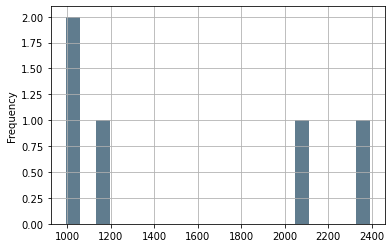

In [ ]:
rslt_df = simulations_results[simulations_results['parameters_index'] == 1]
rslt_df['N'].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')

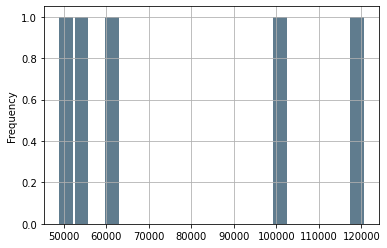

In [ ]:
rslt_df['tau'].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')

In [ ]:
simulations_results.tail(20)

,parameters_index,tau,N,Ascl2_freq,Bbx_freq,Foxa2_freq,Mafb_freq,measurements_exceeded
518,10.0,3.487331e+02,3.0,0,0,0.333333,0.666667,False
519,10.0,3.695114e+03,73.0,0,0,0.0136986,1,False
520,10.0,4.286411e+02,7.0,0,0,0.142857,1,False
521,10.0,2.088521e+02,2.0,0,0,0.5,1,False
522,10.0,2.726614e+04,571.0,0,0,0.00175131,0.998249,False
523,11.0,3.487331e+02,3.0,0,0,0.333333,0.666667,False
524,11.0,8.906219e+03,166.0,0,0,0.0060241,0.993976,False
525,11.0,8.767298e+03,196.0,0,0,0.00510204,0.994898,False
526,11.0,6.325643e+03,125.0,0,0,0.008,0.992,False
527,11.0,3.628505e+03,88.0,0,0,0.0113636,0.988636,False


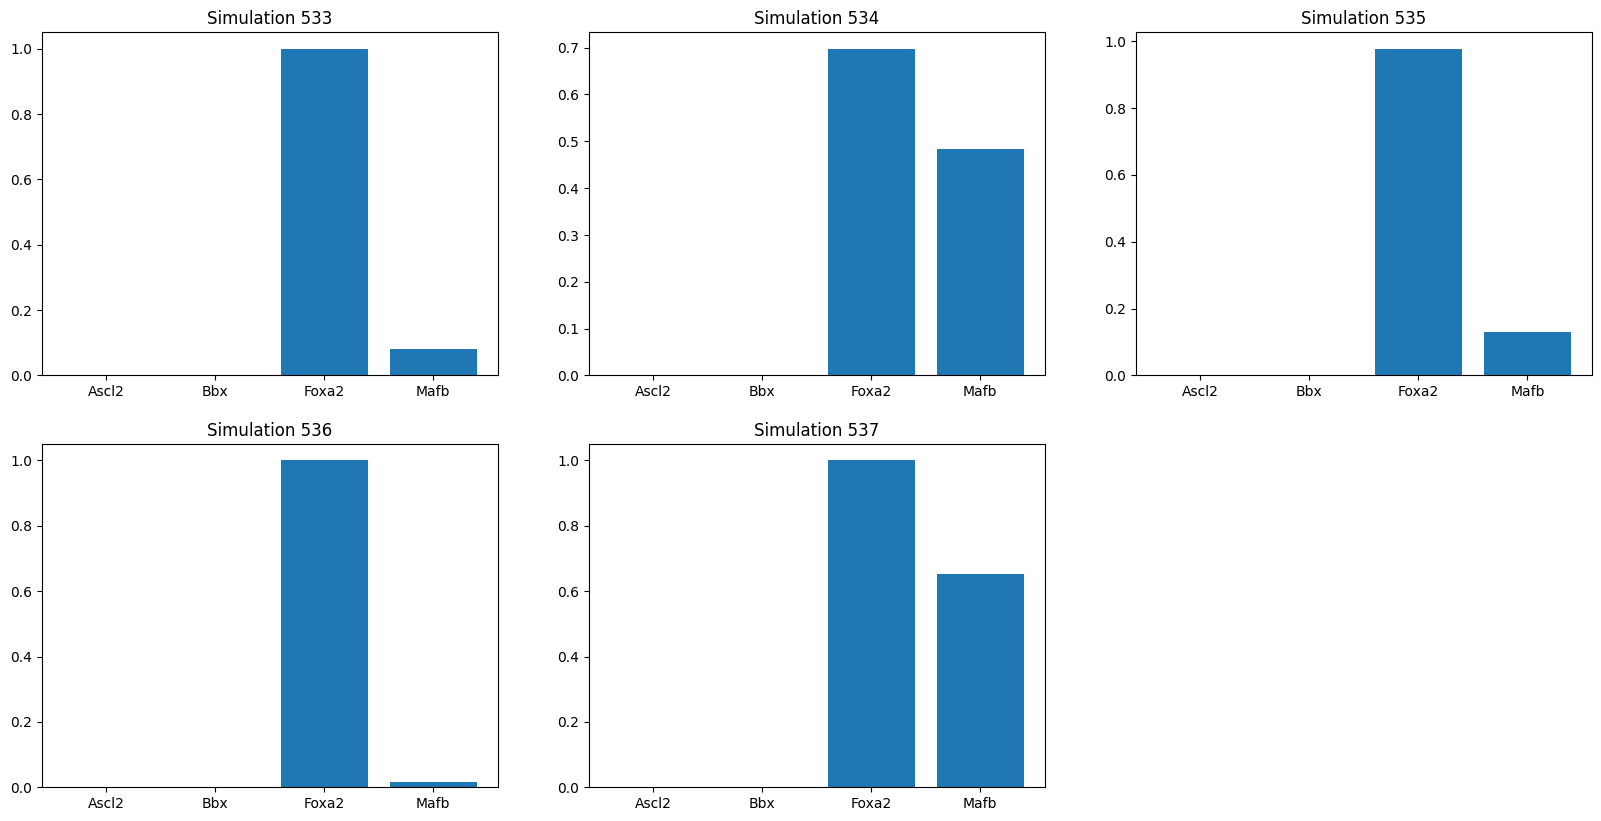

In [ ]:
simulation_index = list(range(533, 538))

plt.figure(figsize=(20,10), dpi=100)

for i, index in enumerate(simulation_index):
  plt.subplot(2, 3, i+1)
  plt.title("Simulation "+str(index))
  freq = [simulations_results[phen+"_freq"][index] for phen in genotype_networks_4phen.keys()]
  plt.bar([phen for phen in genotype_networks_4phen.keys()], freq)

plt.show()

## Evolution paths analysis

Read all evolution paths or a given one

In [176]:
def allEvolutionPaths():
  # return in a dictionary with keys the simulations index and saves the evolution paths
  all_evolution_paths = {}
  files = ls("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/evolution_paths_QW/")

  for file in files:
    all_evolution_paths[int(file[:-4])] = pd.read_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/"
      +"evolution_paths_QW/"+file, index_col=0)
    
  return all_evolution_paths

def evolutionPath(simulation_index):
  return pd.read_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/evolution_paths_QW/"+
                               str(simulation_index)+".csv", index_col=0)

In [177]:
all_evolution_paths = allEvolutionPaths()

In [178]:
evolution_path0 = evolutionPath(0)

In [179]:
all_evolution_paths[0]

,holding time,accumulated time,genotype index,genotype sequence,Ascl2 freq.,Bbx freq.,Foxa2 freq.,Mafb freq.
0,0.000000,0.000000,552,ATGAAAAA,0.0,0.0,0.000000,1.000000
1,4.530709,4.530709,552,ATGAAAAA,0.0,0.0,0.000000,1.000000
2,47.924004,52.454714,552,ATGAAAAA,0.0,0.0,0.000000,1.000000
3,42.701525,95.156238,552,ATGAAAAA,0.0,0.0,0.000000,1.000000
4,30.087254,125.243492,552,ATGAAAAA,0.0,0.0,0.000000,1.000000
...,...,...,...,...,...,...,...,...
4996,88.302397,253137.555930,376,AAATAATT,0.0,0.0,0.605084,0.394916
4997,30.151671,253167.707601,376,AAATAATT,0.0,0.0,0.605163,0.394837
4998,199.753325,253367.460926,376,AAATAATT,0.0,0.0,0.605242,0.394758
4999,76.834697,253444.295623,376,AAATAATT,0.0,0.0,0.605321,0.394679


# Classic evolution (CTRW)

### Auxiliar functions

In [28]:
def infinitesimalGenerator(G, gamma):
  # gamma is the mutation rate 

  A = nx.laplacian_matrix(G)
  H = -gamma* A

  return H

In [72]:
def nextState(states, i, Q):
  # choose next state to jump to from the i-th row of the jump process transition matrix
  # states are the set of state of the random walk
  # i is the actual state
  # Q is the infinitesimal generator of the continuous random walk
  probs = [-Q[i, j]/Q[i, i] for j in states]
  probs[i] = 0 

  return np.random.choice(states, p = probs)

In [70]:
for j in gspace_4phen.nodes:
  if probs[j] < 0:
    print(j, probs[j])

0 -1.0


### Write and reading



In [ ]:
#parameters_c = pd.DataFrame(columns=['initial_phen', 'initial_gen', 'initial_gen_index', 'max_jumps', 'transition_rate'])

In [ ]:
#estimations_results_c = pd.DataFrame(columns=['tau_Ascl2_prom (seconds)', 'tau_Ascl2_prom (days)', 'N_Ascl2_prom', 
#                  'tau_Bbx_prom (seconds)', 'tau_Bbx_prom (days)', 'N_Bbx_prom', 'tau_Mafb_prom (seconds)', 
#                  'tau_Mafb_prom (days)', 'N_Mafb_prom', 'tau_Foxa2_prom (seconds)', 'tau_Foxa2_prom (days)', 'N_Foxa2_prom'])

#simulations_results_c = pd.DataFrame(columns =['parameters_index', 'tau_Ascl2', "tau_Bbx", "tau_Foxa2", "tau_Mafb", 'N_Ascl2', 
#                  "N_Bbx", "N_Foxa2", "N_Mafb"])

Read last results

In [30]:
parameters_c = pd.read_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/CW_parameters.csv", index_col=0)
simulations_results_c = pd.read_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/CW_simulations_results.csv", index_col=0)
estimations_results_c = pd.read_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/CW_estimation_results.csv", index_col=0)

In [31]:
simulations_results_c

,parameters_index,tau_Ascl2,tau_Bbx,tau_Foxa2,tau_Mafb,N_Ascl2,N_Bbx,N_Foxa2,N_Mafb


In [32]:
estimations_results_c

,tau_Ascl2_prom (seconds),tau_Ascl2_prom (days),N_Ascl2_prom,tau_Bbx_prom (seconds),tau_Bbx_prom (days),N_Bbx_prom,tau_Mafb_prom (seconds),tau_Mafb_prom (days),N_Mafb_prom,tau_Foxa2_prom (seconds),tau_Foxa2_prom (days),N_Foxa2_prom


In [33]:
parameters_c

,initial_phen,initial_gen,initial_gen_index,max_jumps,transition_rate
0,Mafb,ATGAAAAA,552,5000,0.001


Write results

In [ ]:
parameters_c.to_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/CW_parameters.csv")
simulations_results_c.to_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/CW_simulations_results.csv")
estimations_results_c.to_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/CW_estimation_results.csv")

### Choosing new parameters

In [ ]:
max_jumps = 5000 # maximum number of jumps in a simulation
# McFadden and Al-Khalili (1999) estimated that it is between 1-100 seconds or more
gamma = 10**(-3) # transition rate between neighbor nodes
initial_phen = 'Mafb'

In [ ]:
np.random.seed(2021)
new_parameters = True
initial_genotype =  randomInitialGenotype(initial_phen)
initial_sequence = gspace_4phen.nodes[initial_genotype]['sequence']

#initial_sequence = "ACAAAAAA"
#initial_genotype = sequenceIndex(initial_sequence)

print(initial_genotype)
print(gspace_4phen.nodes[initial_genotype]['phenotypeName'])

552
['Mafb']


In [ ]:
parameters_c = parameters_c.append({'initial_phen': initial_phen, 'initial_gen': initial_sequence, 'initial_gen_index': int(initial_genotype), 
                                'max_jumps': int(max_jumps), 'transition_rate': gamma}, ignore_index=True)

### Choosing old parameters

In [34]:
parameters_c

,initial_phen,initial_gen,initial_gen_index,max_jumps,transition_rate
0,Mafb,ATGAAAAA,552,5000,0.001


In [35]:
parameters_index = 0

In [36]:
new_parameters = False
max_jumps = parameters_c.loc[parameters_index]['max_jumps'] # maximum number of jumps in a simulation
gamma = parameters_c.loc[parameters_index]['transition_rate'] # transition rate between neighbor nodes
initial_phen = parameters_c.loc[parameters_index]['initial_phen']
initial_genotype = parameters_c.loc[parameters_index]['initial_gen_index']
print(initial_genotype)
print(gspace_4phen.nodes[initial_genotype]['phenotypeName'])

552
['Mafb']


### Loading fix parameters

In [37]:
H = infinitesimalGenerator(gspace_4phen, gamma)
M = gspace_4phen.number_of_nodes() # number of nodes and dimension of Hilbert space

In [50]:
H[552, 552]

-0.003

## Simulations

In [38]:
simulations = 1 # number of simulations

In [85]:
simulations_results_c

,parameters_index,tau_Ascl2,tau_Bbx,tau_Foxa2,tau_Mafb,N_Ascl2,N_Bbx,N_Foxa2,N_Mafb
0,0.0,4.528002,0.980002,0.014932,0.0,793.0,141.0,2.0,0.0


In [74]:
if new_parameters:
  parameters_index = len(parameters_c)-1

tau = {} # estimation of tau (hitting time) for every phenotype 
# Time it takes quantum walk to find given phenotype

N = {} # estimation of N 
# number of jumps the random walk takes to find a genotype with a new phenotype

phenotype_frequency = {} # for saving phenotype frequency in evolution path
evolution_path_columns = ["holding time", "accumulated time", "genotype index", "genotype sequence"]

for phen in genotype_networks_4phen.keys():
  evolution_path_columns.append(phen + " freq.")

for i in range(simulations):
  print('Start of simulation', i+1, '/', simulations)
  jump = 0
  time = 0
  
  #initialization
  for phen in genotype_networks_4phen.keys():
    tau[phen] = -1
    N[phen] = -1

  evolution_path = pd.DataFrame(columns=evolution_path_columns) # indices of genotypes of the evolution 
  actual_state = initial_genotype 

  evolution_path_aux = {}
  # phenotypes of actual state
  phenotypes_actual_state = gspace_4phen.nodes[actual_state]['phenotypeName']
  # the other phenotypes in genotype space
  phenotypes_actual_state_complement = set(genotype_networks_4phen.keys()).difference(set(phenotypes_actual_state))

  for phen in phenotypes_actual_state:
    evolution_path_aux[phen+" freq."] = 1.0

  for phen in phenotypes_actual_state_complement:
    evolution_path_aux[phen+" freq."] = 0.0

  evolution_path_aux['holding time'] = 0.0
  evolution_path_aux['accumulated time'] = 0.0
  evolution_path_aux['genotype index'] = int(initial_genotype)
  evolution_path_aux['genotype sequence'] = gspace_4phen.nodes[initial_genotype]['sequence']

  evolution_path = evolution_path.append(evolution_path_aux, ignore_index=True)

  while jump < max_jumps:
    for phen in phenotypes_actual_state:
      if tau[phen] < 0: # update hitting times of novel phenotypes
        tau[phen] = time
        N[phen] = jump

    T = expon.rvs(scale = -H[actual_state, actual_state], size=1)[0] # sample of exponential distribution

    evolution_path_aux['holding time'] = T
    evolution_path_aux['accumulated time'] = T+time

    for phen in phenotypes_actual_state:
      evolution_path_aux[phen+" freq."] = (evolution_path[phen+" freq."][jump]*time+T)/(time+T)

    for phen in phenotypes_actual_state_complement:
      evolution_path_aux[phen+" freq."] = (evolution_path[phen+" freq."][jump]*time)/(time+T)
    
    # choice next random state
    actual_state = nextState(list(gspace_4phen.nodes), actual_state, H)
    evolution_path_aux['genotype index'] = actual_state
    evolution_path_aux['genotype sequence'] = gspace_4phen.nodes[actual_state]['sequence']

    evolution_path = evolution_path.append(evolution_path_aux, ignore_index=True)

    # phenotypes of actual state
    phenotypes_actual_state = gspace_4phen.nodes[actual_state]['phenotypeName']
    # the other phenotypes in genotype space
    phenotypes_actual_state_complement = set(genotype_networks_4phen.keys()).difference(set(phenotypes_actual_state))
    
    time += T
    jump += 1
    
    if jump % 1000 == 0:
      print("Jump number", jump)
      print("Accumulated time", time)
  
  print("End of simulation", i+1)
    
  simulations_results_aux = {'parameters_index': int(parameters_index)}

  for phen in genotype_networks_4phen.keys():
    simulations_results_aux['tau_'+phen] = tau[phen]
    simulations_results_aux['N_'+phen] = N[phen]


  simulations_results_c = simulations_results_c.append(simulations_results_aux, ignore_index=True)
  evolution_path.to_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/evolution_paths_CW/"+
                                   str(len(simulations_results_c)-1)+".csv")
  
# writing results of simulations
simulations_results_c.to_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/CW_simulations_results.csv")

Start of simulation 1 / 1
Jump number 1000
Accumulated time 5.756654014692395
Jump number 2000
Accumulated time 10.71734385079235
Jump number 3000
Accumulated time 16.3540353621498
Jump number 4000
Accumulated time 21.926935609469453
Jump number 5000
Accumulated time 27.074421116464816
End of simulation 1


In [76]:
parameters_c

,initial_phen,initial_gen,initial_gen_index,max_jumps,transition_rate
0,Mafb,ATGAAAAA,552,5000,0.001


In [77]:
simulations_results_c

,parameters_index,tau_Ascl2,tau_Bbx,tau_Foxa2,tau_Mafb,N_Ascl2,N_Bbx,N_Foxa2,N_Mafb
0,0.0,4.528002,0.980002,0.014932,0.0,793.0,141.0,2.0,0.0


## Evolution paths analysis

Read all evolution paths or a given one

In [94]:
def allEvolutionPaths_c():
  # return in a dictionary with keys the simulations index and saves the evolution paths
  all_evolution_paths = {}
  files = ls("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/evolution_paths_CW/")

  for file in files:
    all_evolution_paths[int(file[:-4])] = pd.read_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/evolution_paths_CW/"+
                               file, index_col=0)
    
  return all_evolution_paths

def evolutionPath_c(simulation_index):
  return pd.read_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/evolution_paths_CW/"+
                               str(simulation_index)+".csv", index_col=0)

In [98]:
all_evolution_paths = allEvolutionPaths_c()

In [99]:
type(all_evolution_paths[0])

pandas.core.frame.DataFrame

In [90]:
evolution_path0 = evolutionPath_c(0)

In [91]:
evolution_path0

,holding time,accumulated time,genotype index,genotype sequence,Ascl2 freq.,Bbx freq.,Foxa2 freq.,Mafb freq.
0,0.000000,0.000000,552,ATGAAAAA,0.000000,0.000000,0.000000,1.000000
1,0.004194,0.004194,541,ATCAAAAA,0.000000,0.000000,0.000000,1.000000
2,0.010737,0.014932,259,ATCAAACA,0.000000,0.000000,0.000000,1.000000
3,0.000362,0.015294,541,ATCAAAAA,0.000000,0.000000,0.023679,0.976321
4,0.006710,0.022004,259,ATCAAACA,0.000000,0.000000,0.016458,0.983542
...,...,...,...,...,...,...,...,...
4996,0.011328,27.053835,467,AGTGTTTA,0.388713,0.040359,0.471756,0.127240
4997,0.007486,27.061320,252,ATTGTTTA,0.388606,0.040348,0.471903,0.127205
4998,0.009236,27.070556,366,ATTGTGTA,0.388473,0.040334,0.472083,0.127161
4999,0.002481,27.073038,363,ATTATGTA,0.388438,0.040331,0.472131,0.127150


### Analysis

In [ ]:
distance(gspace_4phen.nodes[evolution_path0[0]]['sequence'], gspace_4phen.nodes[evolution_path0[151]]['sequence'])

1